## [DSAN5650 Lab] Bayesian Workflow: A Modeling Adventure

In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100..900;1,100..900&display=swap');
.jp-RenderedHTMLCommon {
    font-family: "Roboto", sans-serif;
}
</style>

In [2]:
import os
os.environ[ 'MPLCONFIGDIR' ] = './tmp/'
%config IPCompleter.use_jedi = False

import pandas as pd
import numpy as np
rng = np.random.default_rng(seed=5660)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
# sns.set_style('whitegrid')
cb_palette = ['#e69f00','#56b4e9','#009e73']
sns.set_palette(cb_palette)
import patchworklib as pw;

import pymc as pm
import arviz as az

<Figure size 100x100 with 0 Axes>

## [Part 1] Elden Coin: The Immersive Coin-Flipping RPG That's Taking the World By Storm!

### [Part 1.1] The Rules of the Game

* A friend $B$ challenges you ($A$) to a **match** of Elden Coin ($B$ provides their Elden Coin, as well as the table to play on, which is a key part of the game), a tabletop coin-flipping game
* A **match** is a series of **50 rounds**
* At the start of each round, both you and $B$ put **one Euro** (€1) into the pot on the side of the table, then write a big "0" in chalk on the other side
* Then, the round consists of you and $B$ taking turns flipping the Elden Coin in the center of the table until you've reached **13 total flips**
* Every time a flip comes up **Heads**, you add one to the number written in chalk (by erasing and rewriting it)
* At the end of the round:
    * If the number of heads written down is **above 6**, you ($A$) win the entire pot (€2), meaning that you gain an additional Euro above the amount you entered the round with.
    * Otherwise, $B$ wins the entire pot, meaning that you lose one Euro relative to the amount you entered the round with.

The following cell defines a `Game` class, that we can use to store the different parameters we'll need when simulating a match.

In [3]:
class Game:
    flips_per_round = 13
    num_heads_range = (0, flips_per_round)
    num_heads_support = list(range(0, flips_per_round + 1))
    win_cutoff = 6
    rounds_per_match = 50

Then, on top of just the rules of the game itself, here we define a separate set of globals "outside of" the game, specifying the number of simulations of the game we'd like to run in our simulation cells (so that, for example, you can set it to lower values if running on a slower computer or if you just want the cells to run more quickly!)

In [4]:
class MyGlobals:
    # If we're trying to get a distribution over what might happen in *one round*
    # of the game (with outcomes Win or Lose), we'll use this many simulations
    rounds_to_sim = 10_000
    # Otherwise, for obtaining a distribution over what might happen in a *match*
    # (with the outcome being the total amount of money won or lost), we'll use
    # this many
    matches_to_sim = 1_000

### [Part 1.2] Simulating a Round

If we *truly* wanted to work at the most fine-grained level, we could simulate individual coin flips, one-by-one

In [5]:
def sim_round_flips(p):
    round_flips = rng.choice([0,1],p=[1-p, p], size=Game.flips_per_round)
    return round_flips
print(sim_round_flips(0.5))
print(sim_round_flips(0.85))

[0 0 1 0 0 0 0 0 1 0 1 0 1]
[1 0 1 1 1 1 1 1 1 1 0 0 1]


Then, to check the outcome at the level of number-of-heads, we could just use `sum()`:

In [6]:
sum(sim_round_flips(0.5))

6

But, if we're going to just sum up the individual coin flips anyways, we can achieve a pretty massive speed improvement (not noticeable for only one or a few rounds, but massive once we move to the level of simulating thousands of rounds) by using `rng.binomial()`, that is, by operating at the coarser-grained level of generating [number of heads out of 9 flips] rather than individual 0/1 heads/tails values:

In [7]:
def sim_round(p):
    num_heads = int(rng.binomial(n=Game.flips_per_round, p=p, size=1))
    return num_heads
sim_round(0.5)

6

So, let's do some simulations (we'll use `MyGlobals.rounds_to_sim`, set above, as our number of simulations $N$), by running this function a bunch of times, to see how often the number of heads is above 6 when the coin is fair...

In [8]:
def get_counts(df):
    support_df = pd.DataFrame({'num_heads': Game.num_heads_support})
    count_df = df['num_heads'].value_counts().reset_index().sort_values(by='num_heads')
    merged_df = support_df.merge(count_df, on='num_heads', how='left')
    merged_df['win'] = merged_df['num_heads'] > Game.win_cutoff
    merged_df['count'] = merged_df['count'].replace(np.nan, 0).astype(int)
    merged_df['Pr(num_heads)'] = merged_df['count'] / merged_df['count'].sum()
    return merged_df

fair_sim_result = [sim_round(0.5) for _ in range(MyGlobals.rounds_to_sim)]
fair_sim_df = pd.DataFrame({'num_heads': fair_sim_result, 'params': 'p = 0.5'})
fair_sim_df['win'] = fair_sim_df['num_heads'] > Game.win_cutoff
fair_count_df = get_counts(fair_sim_df)
fair_count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
num_heads,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,0,22,116,376,874,1593,1990,2065,1577,890,382,101,13,1
win,False,False,False,False,False,False,False,True,True,True,True,True,True,True
Pr(num_heads),0.0,0.0022,0.0116,0.0376,0.0874,0.1593,0.199,0.2065,0.1577,0.089,0.0382,0.0101,0.0013,0.0001


And we can plot the distribution of these simulated outcomes, assigning different colors to the outcomes where we win and where we lose: 

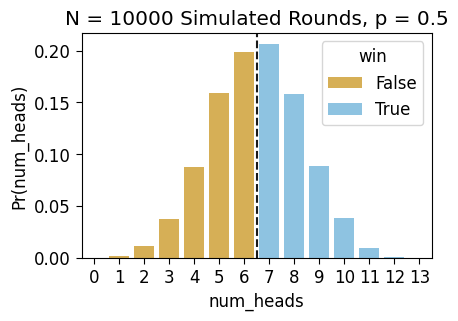

In [9]:
ax = pw.Brick(figsize=(3.5,2.25))
g = sns.barplot(
    x="num_heads", y="Pr(num_heads)", hue="win", data=fair_count_df,
    alpha=0.75, ax=ax
);
ax.axvline(x=6.5, ls='dashed', color='black', alpha=0.9);
ax.set_title(f"N = {len(fair_sim_result)} Simulated Rounds, p = 0.5")
ax.savefig()

To make it even more straightforward to see the fairness of the game (given a fair coin!), we can just plot win and loss proportions directly:

In [10]:
fair_win_df = fair_count_df[['win','count']].groupby("win").sum().reset_index()
fair_win_df

,win,count
0,False,4971
1,True,5029


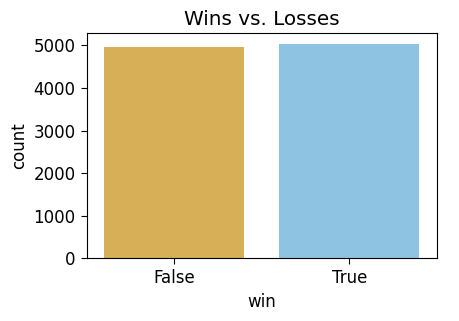

In [11]:
ax = pw.Brick(figsize=(3.5,2.25))
win_plot = sns.barplot(
    x="win", y="count", hue="win",
    data=fair_win_df,
    alpha=0.75, ax=ax, legend=False
);
win_plot.set_title("Wins vs. Losses")
ax.savefig()

### [Part 1.3] Checking the Math

So far, individual rounds of this game look pretty fair. But, can we be *mathematically sure* they are?

Let's say we didn't even trust this $N = 10000$ simulation. Something that I think is good to have in your toolkit, for checking the math on this stuff without needing to take out a piece of paper, is a **symbolic mathematics system!**

`SymPy`, in this case, can be used to derive exact closed-form solutions (when possible) to probability theory problems, so that you don't even have to depend on running simulations for simple enough problems! You can find the documentation for the `SymPy` stats module [here](https://docs.sympy.org/latest/modules/stats.html), but the following cells should give you the gist as we check the math of the game's fairness.

As a quick demonstration of why SymPy is useful, let's say we're trying to remember the [formula for the sum of the first $n$ natural numbers](https://math.stackexchange.com/questions/2260/proof-that-1234-cdotsn-fracn-timesn12)... Is Python able to help us here on its own?

In [12]:
def sum_up_to(n):
    return sum(range(1, n+1))

In [13]:
sum_df = pd.DataFrame({'n': list(range(1, 7))})
sum_df['sum_1_to_n'] = sum_df['n'].apply(sum_up_to)
sum_df.T

,0,1,2,3,4,5
n,1,2,3,4,5,6
sum_1_to_n,1,3,6,10,15,21


One option would be to stare at this and try to figure out the pattern until we remember... Which is fine but, my brain is too tired to do that, which is why I wanted the computer to do it for me in the first place! Instead, let's let `SymPy` try it:

In [14]:
from sympy import expand, oo, plot, simplify, symbols, Eq, Rational, Sum

In [15]:
i = symbols('i', integer=True)
n = symbols('n', integer=True)
my_sum = Sum(i, (i, 1, n))
my_sum

Sum(i, (i, 1, n))

This is the thing we're trying to remember the formula for... so let's as `SymPy` to `.doit()`!

In [16]:
my_result = my_sum.doit()
my_result

n**2/2 + n/2

...Already very cool, but we can get it in an even more familiar form by using `simplify()` as well:

In [17]:
simplify(my_result)

n*(n + 1)/2

And we can ask it to derive exact, closed-form solutions for a bunch of other things too! For now, we can try sums of squares...

In [18]:
simplify(Sum(i**2, (i, 1, n)).doit())

n*(2*n**2 + 3*n + 1)/6

Or the sum of a [geometric series](https://en.wikipedia.org/wiki/Geometric_series) $\sum_{i=1}^{\infty}ar^i$...

In [19]:
a = symbols('a', nonnegative=True)
r = symbols('r', nonnegative=True)
my_geo_sum = Sum(a * (r ** i), (i, 0, oo))
my_geo_result = my_geo_sum.doit()
my_geo_result

a*Piecewise((1/(1 - r), r < 1), (Sum(r**i, (i, 0, oo)), True))

And now that we have the formula, we could plug in a specific value for $r$ as well (here $r = \frac{1}{5}$):

In [20]:
my_geo_result.subs(r, Rational(1,5))

5*a/4

Now we can import from the `sympy.stats` module, and compute exact values for the probabilities of each possible round result!

In [21]:
from sympy.stats import P, E, density, Bernoulli, DiscreteUniform

Defining a sequence of i.i.d. RVs in `SymPy` is a bit tough in general (meaning, for example, it'd be tough to get it to prove the Central Limit Theorem), but, for simple cases like this where we're summing up a finite number of coin flips, the following works!

We'll use `Z` to represent the sum of the 13 coin flips, or in other words, the **number of heads** in a round of Elden Coin, now modeled **exactly** (without rounding or approximations), rather than simulated:

In [22]:
coins = [Bernoulli(f'X{i}', p=Rational(1,2)) for i in range(0, Game.flips_per_round)]
Z = sum(coins)
Z

X0 + X1 + X10 + X11 + X12 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9

We can use the `E()` function imported above to get the exact **expected value** of the sum of 13 coin flips:

In [23]:
E(Z)

13/2

And then the `P()` function to compute **probabilities**. For example, we can use Python's built-in **inequality** operator `>` in this case to find the thing we're looking for: the game is fair if $\Pr(Z > 6)$ is exactly $1/2$:

In [24]:
P(Z > Game.win_cutoff)

1/2

As a warning if you decide to use `SymPy` for other stuff, though: it does **not** work well with Python's equality operator `==`! For example, if you want to find the probability of a dice roll coming up 5, you might think of the following:

In [25]:
D = DiscreteUniform('D', list(range(1, 7)))
P(D == 5)

0

Awful... 😵 Instead, we have to import **`SymPy`'s symbolic version of `==`**, namely, the equality function `Eq()`. If we use this instead of `==`, we'll (thankfully) get the expected result!

In [26]:
P(Eq(D, 5))

1/6

Ok! Now that you have a feel for `SymPy`, as a final helpful use for it here let's derive the **exact** probability values for the different outcomes of a round of Elden Coin. For that, we can use `SymPy`'s `density()` function on a Random Variable, in this case on $Z$:

In [27]:
pmf_Z = density(Z)
pmf_Z

{0: 1/8192,
 1: 13/8192,
 2: 39/4096,
 3: 143/4096,
 4: 715/8192,
 5: 1287/8192,
 6: 429/2048,
 7: 429/2048,
 8: 1287/8192,
 9: 715/8192,
 10: 143/4096,
 11: 39/4096,
 12: 13/8192,
 13: 1/8192}

And then, for easier viewing/plotting, we can form a Pandas `DataFrame` from these values:

In [28]:
Z_df = pd.DataFrame({'X':pmf_Z.keys(), 'Pr(X)':pmf_Z.values()})
Z_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
X,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Pr(X),1/8192,13/8192,39/4096,143/4096,715/8192,1287/8192,429/2048,429/2048,1287/8192,715/8192,143/4096,39/4096,13/8192,1/8192


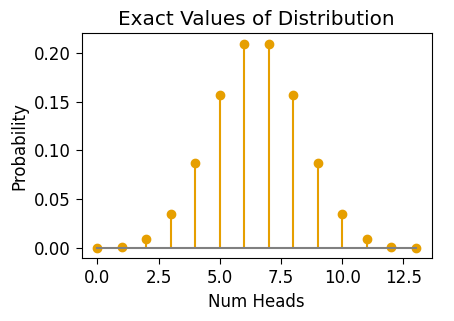

In [29]:
ax = pw.Brick(figsize=(3.5,2.25))
ax.stem("X", "Pr(X)", data=Z_df, basefmt='grey');
ax.set_title("Exact Values of Distribution");
ax.set_xlabel("Num Heads");
ax.set_ylabel("Probability")
# ax.grid(False);
#ax.set_facecolor('white');
ax.savefig()

Sadly though, if you're like me and you prefer `seaborn` to "base" `matplotlib`, `seaborn` doesn't work well with the exact-numeric-value format of `SymPy` for fractions. So, for `seaborn` plotting you'll have to convert to (non-exact) Python `float` values. But still, you'll be plotting the closest possible `float` approximation to the true values!

In [30]:
approx_df = Z_df.copy()
approx_df['X'] = approx_df['X'].astype(int)
approx_df['Pr(X)'] = approx_df['Pr(X)'].astype(float)
approx_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
X,0.000000,1.000000,2.000000,3.000000,4.00000,5.000000,6.000000,7.000000,8.000000,9.00000,10.000000,11.000000,12.000000,13.000000
Pr(X),0.000122,0.001587,0.009521,0.034912,0.08728,0.157104,0.209473,0.209473,0.157104,0.08728,0.034912,0.009521,0.001587,0.000122


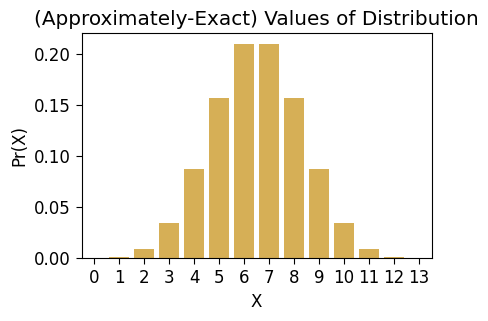

In [31]:
ax = pw.Brick(figsize=(3.5,2.25))
sns.barplot(
    x="X", y="Pr(X)", data=approx_df,
    ax=ax, alpha=0.75
);
ax.set_title("(Approximately-Exact) Values of Distribution")
# ax.grid(False);
#ax.set_facecolor('white');
ax.savefig()

### [Part 1.4] Simulating Many Rounds

Now that we've convinced ourselves, both via simulation and exact-math, that a single round is fair, let's move to simulating **matches**, comprised of 50 rounds! This is what we really care about, since it will tell us the **range** our winnings/losings might take on at the end of a full match.

The functions in the following cell carry out **simulations** at more coarse-grained levels than an individual round:

**`sim_match(p)`** simulates a 50-round match and produces a Pandas `DataFrame` with the results:

* `t` reprsents the round number (We add a special $t = 0$ "round" to mark the fact that we start with \$0 at the beginning of the game, which will make the plots below more easy to read)
* `num_heads` represents the number of heads at round `t`
* `money_change` is either $-1$ or $1$: $-1$ if `num_heads` was less than 6, and $1$ otherwise, representing the net change in your money at the end of the round
* `money_at_round_end` represents the cumulative sum of `money_change` from round to round, so that at any round this contains the current overall winnings/losings relative to the 0 € starting point at $t = 0$

**`sim_outcome(p)`** allows us to get a sense for the **ranges** of values that can come out of a game, by simulating `MyGlobals.matches_to_sim` matches, and returning two Pandas `DataFrame`s giving us different pieces of information:

* In `final_df`, each row represents a single **round** within one of the simulated matches. We can use this to track the **trajectory** of money over the course of a match, and then, since we're simulating **many** matches, we'll in fact get a **distribution over trajectories**, which will help us visualize our expectations about how much money we may win or lose in a given match.
* In `end_df`, each row represents the **final round** of a simulated match. As we'll see in the plots below, this allows us to visualize the **distribution over final winnings/losings we can expect to see** for a given Elden Coin.

Finally, **`get_result_label(money_at_end)`** is just a helper function for `sim_outcome(p)`: it allows us to "map" the `money_at_round_end` values from `sim_match()` to a three-level Random Variable called `result`, which will have value:

* `"Gained Money"` if we ended the match with more money than we started with,
* `"Lost Money"` if we ended the match with less money than we started with, and
* `"Broke Even"` if we ended the match with exactly the same amount of money that we started with.

In [32]:
def sim_match(p):
    round_outcomes = rng.binomial(n=Game.flips_per_round, p=p, size=Game.rounds_per_match)
    match_df = pd.DataFrame({'t': range(1,Game.rounds_per_match+1), 'num_heads': round_outcomes})
    match_df['money_change'] = -1 + 2 * (match_df['num_heads'] > Game.win_cutoff)
    match_df['money_at_round_end'] = match_df['money_change'].cumsum()
    t0_df = pd.DataFrame({'t':[0],'money_at_round_end':[0],'money_change':[0]})
    match_df = pd.concat([t0_df, match_df])
    return(match_df)

result_order = ['Lost Money', 'Broke Even', 'Gained Money']
def get_result_label(money_at_end):
    if money_at_end > 0:
        return "Gained Money"
    if money_at_end < 0:
        return "Lost Money"
    return "Broke Even"

def sim_outcome(p):  
    all_match_dfs = []
    for m in range(MyGlobals.matches_to_sim):
        match_df = sim_match(p)
        match_df['match_num'] = m
        all_match_dfs.append(match_df)
    # All the data
    final_df = pd.concat(all_match_dfs)
    final_df.insert(0, 'match_num', final_df.pop('match_num'))
    final_df['params'] = f"p = {p}"
    # Just the last round money_at_end
    end_df = final_df[final_df['t'] == Game.rounds_per_match].copy()
    end_df = end_df[['match_num','t','money_at_round_end']]
    end_df['result'] = end_df['money_at_round_end'].apply(get_result_label)
    end_df['result'] = pd.Categorical(
        end_df['result'],
        ordered=True,
        categories=result_order
    )
    end_df['params'] = f"p = {p}"
    return final_df, end_df
fair_final_df, fair_end_df = sim_outcome(0.5)
print("fair_final_df:")
display(fair_final_df.head())
print("fair_end_df:")
display(fair_end_df.head())

fair_final_df:


,match_num,t,money_at_round_end,money_change,num_heads,params
0,0,0,0,0,NaN,p = 0.5
0,0,1,1,1,8.0,p = 0.5
1,0,2,0,-1,6.0,p = 0.5
2,0,3,1,1,9.0,p = 0.5
3,0,4,2,1,8.0,p = 0.5


fair_end_df:


,match_num,t,money_at_round_end,result,params
49,0,50,2,Gained Money,p = 0.5
49,1,50,-10,Lost Money,p = 0.5
49,2,50,-4,Lost Money,p = 0.5
49,3,50,16,Gained Money,p = 0.5
49,4,50,-2,Lost Money,p = 0.5


With `fair_final_df` and `fair_end_df` now ready for use, we can plot the range of **trajectories** (from $t = 0$ to $t = 50$) that a match might exhibit, as well as the distribution of **final winnings/losings** that we may obtain at the end of a match under the specified Elden Coin value of $p$.

For now we'll plot what matches with a **fair coin** might look like, but in the next section we'll produce the same kind of plot for a **biased coin**!

The most straightforward way to visualize the trajectories is probably just to plot **every** "path" through the game space, with a low `alpha` value so that the more-frequent paths appear as a darker orange:

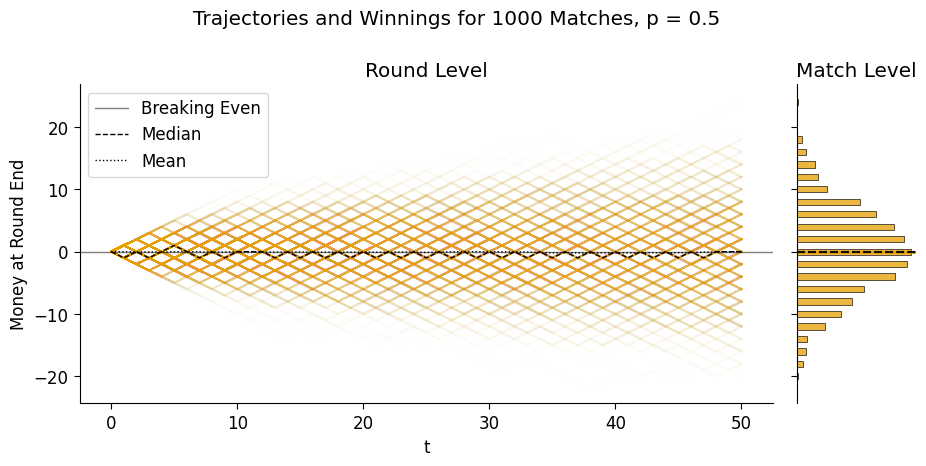

In [33]:
def plot_trajectories(final_df, end_df, suptitle, custom_ylim=None):
    if custom_ylim is None:
        grid = sns.JointGrid(height=4.5);
    else:
        grid = sns.JointGrid(height=4.5, ylim=custom_ylim);
    fair_trajectory_plot = sns.lineplot(
        x="t", y="money_at_round_end", data=final_df, ax=grid.ax_joint,
        units='match_num', estimator=None, alpha=0.02,
    );
    # Breaking-even line
    grid.refline(
        y=0, color='black', lw=1, ls='solid', alpha=0.5, label="Breaking Even"
    );
    # Add the median line in dashed black
    sns.lineplot(
        x="t", y="money_at_round_end", # hue="source",
        data=final_df, ax=grid.ax_joint,
        label="Median",
        estimator='median',
        errorbar=None,
        # errorbar=('pi',90),
        color='black',
        lw=1, ls='dashed',
        err_kws=dict(alpha=0.15),
    );
    # And mean line in dotted black
    sns.lineplot(
        x="t", y="money_at_round_end", # hue="source",
        data=final_df, ax=grid.ax_joint,
        label="Mean",
        estimator='mean',
        errorbar=None,
        # errorbar=('pi',90),
        color='black',
        lw=1, ls='dotted',
        err_kws=dict(alpha=0.15),
    );
    grid.ax_marg_x.remove();
    grid.ax_marg_y.axhline(
        y=end_df['money_at_round_end'].mean(),
        color='#e69f00', lw=2
    );
    # Marginal axis
    winnings_plot = sns.histplot(
        y="money_at_round_end", data=end_df,
        ax=grid.ax_marg_y,
        discrete=True,
    );
    # Dashed line on margin for median
    grid.ax_marg_y.axhline(
        y=end_df['money_at_round_end'].median(), color='black', ls='dashed', alpha=0.9
    );
    # Dotted line on margin for mean
    grid.ax_marg_y.axhline(
        y=end_df['money_at_round_end'].mean(), color='black', ls='dotted', alpha=0.9
    );
    grid.ax_joint.set_title("Round Level");
    grid.ax_marg_y.set_title("Match Level");
    grid.fig.set_figwidth(10);
    grid.fig.suptitle(suptitle);
    grid.ax_joint.set_ylabel("Money at Round End");
    grid.ax_joint.legend(loc="upper left");
    return grid
plot_trajectories(
    fair_final_df, fair_end_df,
    suptitle="Trajectories and Winnings for 1000 Matches, p = 0.5"
);

Though this plot is helpful for seeing the "emergent" distribution of winnings relative to the underlying coin flips, it also makes it difficult to see the median or mean pathways/winnings -- these lines will be difficult to see in this case either way, because they're close to 0 throughout, but being able to see them a bit better will be helpful when we move to biased coins.

So, as an alternative that we'll use from here on out, we can just plot a series of lighter "bands" around the median pathway, containing (from darkest to lightest) the middle 50, 90, and 99 percentiles of `money_at_round_end` across all simulations (note that the band containing the middle 99 percentiles may be cut off, since it may reach extreme negative and positive values when we simulate many matches!)

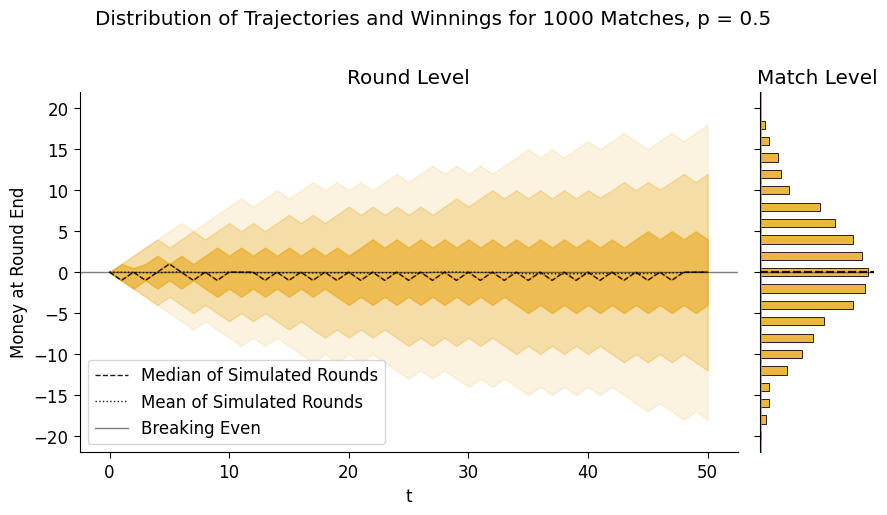

In [34]:
def plot_trajectory_bands(final_df, end_df, suptitle, custom_ylim=None):
    if custom_ylim is not None:
        fair_grid_var = sns.JointGrid(height=5, ylim=(-22,22));
    else:
        fair_grid_var = sns.JointGrid(height=5);
    # Don't need marginal plot on x-axis
    fair_grid_var.ax_marg_x.remove();
    # This ensures that the legend doesn't include params 3 different times
    ftemp_df = final_df.copy()
    ftemp_df['params'] = "_" + ftemp_df['params']
    # Band containing the middle 100 percentiles of all trajectories
    full_range_plot = sns.lineplot(
        x="t", y="money_at_round_end", hue="params",
        data=ftemp_df, ax=fair_grid_var.ax_joint,
        # color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',99),
        lw=1,
        err_kws=dict(alpha=0.125),
    );
    # Band containing middle 90 percentiles
    sns.lineplot(
        x="t", y="money_at_round_end", hue="params",
        data=ftemp_df, ax=fair_grid_var.ax_joint,
        # color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',90),
        lw=1,
        err_kws=dict(alpha=0.25),
    );
    # Band containing middle 50 percentiles
    sns.lineplot(
        x="t", y="money_at_round_end", hue="params",
        data=ftemp_df, ax=fair_grid_var.ax_joint,
        # color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',50),
        lw=1,
        err_kws=dict(alpha=0.5),
    );
    # Median trajectory as dashed black line
    sns.lineplot(
        x="t", y="money_at_round_end", label="Median of Simulated Rounds",
        data=ftemp_df, ax=fair_grid_var.ax_joint,
        color='black', alpha=0.9,
        estimator='median',
        errorbar=None,
        lw=1, ls='dashed',
    );
    # Mean trajectory as dotted black line
    sns.lineplot(
        x="t", y="money_at_round_end", label="Mean of Simulated Rounds",
        data=ftemp_df, ax=fair_grid_var.ax_joint,
        lw=1, ls='dotted', color='black', alpha=0.9,
        estimator='mean',
        errorbar=None,
    );
    # Refline links joint and marginal plots
    fair_grid_var.refline(
        y=0, color='black', lw=1, ls='solid', label='Breaking Even', alpha=0.5
    );
    fair_grid_var.ax_joint.legend(loc="lower left");

    ### Marginal plot
    margin_kde = sns.histplot(
        y="money_at_round_end", data=end_df,
        ax=fair_grid_var.ax_marg_y,
        discrete=True,
        # fill=True,
        legend=False,
    );
    margin_kde = sns.kdeplot(
        y="money_at_round_end", data=end_df,
        ax=fair_grid_var.ax_marg_y,
        fill=True,
        legend=False,
    );
    # Dashed line on margin for median
    fair_grid_var.ax_marg_y.axhline(
        y=end_df['money_at_round_end'].median(), color='black', ls='dashed', alpha=0.9
    );
    # Dotted line on margin for mean
    fair_grid_var.ax_marg_y.axhline(
        y=end_df['money_at_round_end'].mean(), color='black', ls='dotted', alpha=0.9
    );
    fair_grid_var.fig.suptitle(suptitle);
    fair_grid_var.ax_joint.set_ylabel("Money at Round End");
    fair_grid_var.ax_joint.set_title("Round Level");
    fair_grid_var.ax_marg_y.set_title("Match Level");
    fair_grid_var.fig.set_figwidth(9.5);
    return fair_grid_var
plot_trajectory_bands(
    fair_final_df, fair_end_df, custom_ylim=(-25, 25),
    suptitle="Distribution of Trajectories and Winnings for 1000 Matches, p = 0.5"
);

And, like we did with Win vs. Loss for a single **round**, here we can more simply plot the three outcomes we've defined at the match level:

In [35]:
fair_result_df = fair_end_df['result'].value_counts(sort=False, normalize=True).to_frame().reset_index()
fair_result_df

,result,proportion
0,Lost Money,0.440
1,Broke Even,0.117
2,Gained Money,0.443


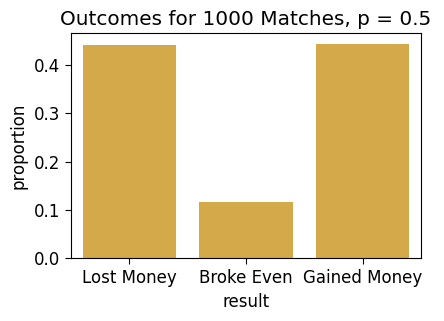

In [36]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.barplot(
    x="result", y="proportion", data=fair_result_df,
    alpha=0.8, ax=ax
);
ax.set_title("Outcomes for 1000 Matches, p = 0.5");
ax.savefig()

## [Part 2] Simulating the Unlockable *Sheisty Coin*

The only problem is... in the new Season 2 of Elden Coin, the company who makes the game (ThumbSoft) has added a new **powerup shop**, which means that now your friend $B$ may have used their Elden Coin earnings to buy a powerup which secretly **biases their Elden Coin** in their favor, turning it into a new evolved form, the **[Shiesty](https://www.oed.com/dictionary/sheisty_adj) Coin**. When someone buys this powerup, it adds a randomly-generated amount of bias to their coin, so that its new probability of Heads is some value (uniformly) between $0.4$ and $0.5$.

So, this means there are two new "layers" of uncertainty in a sense:

* You don't know whether or not your friend has a Sheisty Coin at all, and
* You don't know how much bias was added to their coin if they did purchase the upgrade.

The eventual goal will be to use `PyMC` to **model** this uncertainty explicitly, allowing you to make optimal gameplay choices! 

For now, let's simulate what rounds may look like, then what match-level trajectories and winnings may look like, under a specific biased-coin scenario.

### [Part 2.1] Simulating Biased *Round* Outcomes

The following cells generate and then plot a distribution of simulated **round outcomes** for a Sheisty Coin biased exactly in the middle of the possible range, with $p = 0.45$:

In [37]:
p_biased = 0.45

In [38]:
biased_sim_result = [sim_round(p_biased) for _ in range(MyGlobals.rounds_to_sim)]
biased_sim_df = pd.DataFrame({'num_heads': biased_sim_result, 'params': 'p = 0.45'})
biased_sim_df['win'] = biased_sim_df['num_heads'] > Game.win_cutoff
biased_count_df = get_counts(biased_sim_df)
biased_count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
num_heads,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,8,44,242,665,1353,1983,2177,1699,1150,479,160,38,2,0
win,False,False,False,False,False,False,False,True,True,True,True,True,True,True
Pr(num_heads),0.0008,0.0044,0.0242,0.0665,0.1353,0.1983,0.2177,0.1699,0.115,0.0479,0.016,0.0038,0.0002,0.0


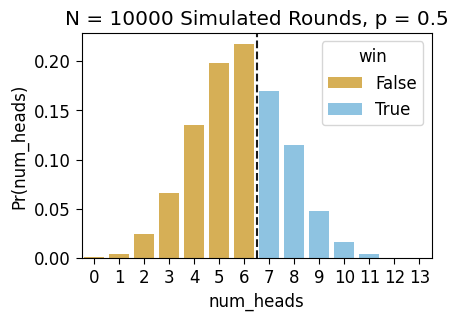

In [39]:
ax = pw.Brick(figsize=(3.5,2.25))
g = sns.barplot(
    x="num_heads", y="Pr(num_heads)", hue="win", data=biased_count_df,
    alpha=0.75, ax=ax
);
ax.axvline(x=6.5, ls='dashed', color='black', alpha=0.9);
ax.set_title(f"N = {len(biased_sim_result)} Simulated Rounds, p = 0.5")
ax.savefig()

And we can also plot the kernel densities of the two `num_heads` distributions, to compare the biased and fair outcomes visually:

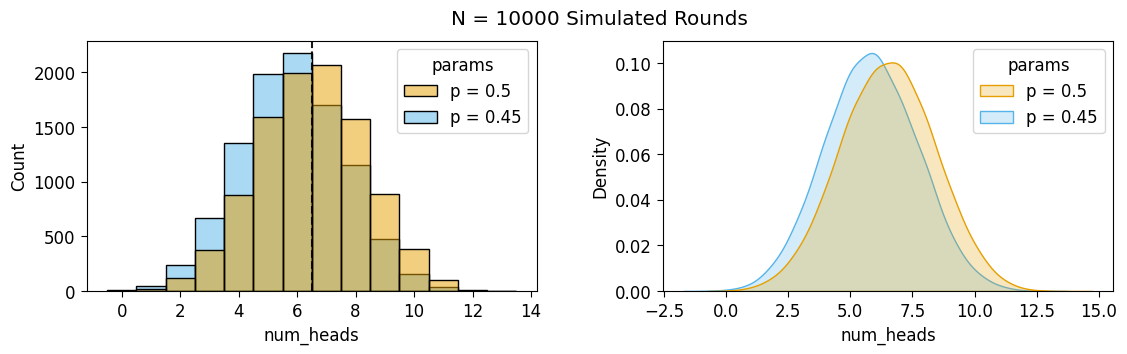

In [40]:
combined_sim_df = pd.concat([fair_sim_df, biased_sim_df])
combined_sim_df

# Histogram (confusing imo)
ax1 = pw.Brick(figsize=(4.5,2.5))
sns.histplot(
    x="num_heads", hue="params", data=combined_sim_df, ax=ax1,
    discrete=True
    # fill=True, bw_adjust=2
);
ax1.axvline(x=6.5, ls='dashed', color='black', alpha=0.9);
# KDE Plot (more helpful imo!)
ax2 = pw.Brick(figsize=(4.5, 2.5))
sns.kdeplot(
    x="num_heads", hue="params", data=combined_sim_df, ax=ax2,
    fill=True, bw_adjust=2
);
ax12 = ax1 | ax2
ax12.set_suptitle(f"N = {len(biased_sim_result)} Simulated Rounds")
ax12.savefig()

### [Part 2.2] Simulating Biased *Match* Outcomes

The above plot shows the bias relative to a single *round* of the game, but let's also generate a plot to see what this looks like when we run **50 matches**. We'll plot both the $p = 0.5$ and $p = 0.45$ trajectories so you can get a comparative sense:

In [41]:
biased_final_df, biased_end_df = sim_outcome(p_biased)
print("biased_final_df:")
display(biased_final_df.head())
print("biased_end_df:")
display(biased_end_df.head())

biased_final_df:


,match_num,t,money_at_round_end,money_change,num_heads,params
0,0,0,0,0,NaN,p = 0.45
0,0,1,-1,-1,5.0,p = 0.45
1,0,2,0,1,11.0,p = 0.45
2,0,3,-1,-1,5.0,p = 0.45
3,0,4,0,1,7.0,p = 0.45


biased_end_df:


,match_num,t,money_at_round_end,result,params
49,0,50,-10,Lost Money,p = 0.45
49,1,50,-22,Lost Money,p = 0.45
49,2,50,-8,Lost Money,p = 0.45
49,3,50,-12,Lost Money,p = 0.45
49,4,50,-10,Lost Money,p = 0.45


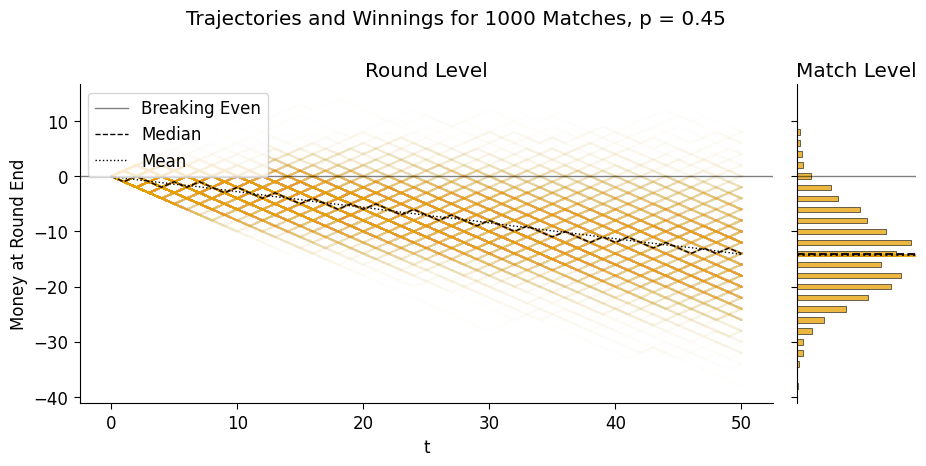

In [42]:
plot_trajectories(
    biased_final_df, biased_end_df,
    suptitle="Trajectories and Winnings for 1000 Matches, p = 0.45"
);

And then, if we plot just the mean amount of money at the end of each round, averaged across simulations, we can compare the two trajectories on the same plot:

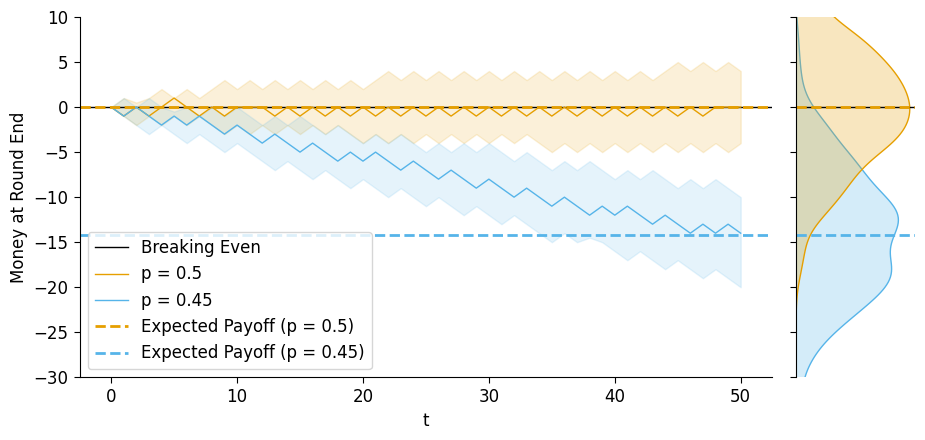

In [43]:
combined_final_df = pd.concat([fair_final_df, biased_final_df])
combined_end_df = pd.concat([fair_end_df, biased_end_df])

biased_grid = sns.JointGrid(height=5, ylim=(-30,10));
biased_grid.refline(y=0, color='black', lw=1, ls='solid', label='Breaking Even');
# Mean lines
sns.lineplot(
    x="t", y="money_at_round_end", hue="params",
    data=combined_final_df, ax=biased_grid.ax_joint,
    estimator='median',
    #errorbar=None,
    errorbar=('pi',50),
    lw=1,
    err_kws=dict(alpha=0.15),
);
biased_grid.ax_marg_x.remove();
biased_grid.refline(
    y=fair_end_df['money_at_round_end'].mean(),
    color=cb_palette[0], lw=2,
    label='Expected Payoff (p = 0.5)'
);
biased_grid.refline(
    y=biased_end_df['money_at_round_end'].mean(),
    color=cb_palette[1], lw=2,
    label='Expected Payoff (p = 0.45)'
);
biased_grid.ax_joint.legend(loc="lower left");
# plt.legend(['Breaking Even','Your Expected Payoff'], loc="left")

sns.kdeplot(
    y="money_at_round_end", hue="params", data=combined_end_df,
    ax=biased_grid.ax_marg_y, fill=True, legend=False,
    # stat='density',
    # discrete=True,
    # shrink=0.5,
);
biased_grid.ax_joint.set_ylabel("Money at Round End");
biased_grid.fig.set_figwidth(10)

And from this plot we can see how, the median trajectories begin to noticeably depart from about $t = 5$ onwards, and then even the **intervals containing the middle 50%** of end-of-round money amounts begin to separate from about $t = 26$ onwards.

## [Part 3] Moving to PyMC: Modeling the Season 2 Dynamic

So far, it seems like playing your friend is a capital-B capital-D Bad Deal for you! Which raises the question...

### [Part 3.1] Why Would You Play At All?

The short answer is that... this is not so far removed from the structure of e.g. a lottery, or just gambling in general: you get the thrill of the small chance of winning big, and meanwhile, if $B$ was for example a US state, they would get the revenue from their state lottery.

In **Elden Coin** specifically, though, the idea is that you can similarly **win big** if you beat someone who has a **Sheisty Coin**, because of a game mechanic that the developers released alongside the new powerup shop:

* If you beat someone **without** the coin, you get the "standard", expected money amount given by the rules of the game. However,
* If you beat someone **with** the Sheisty Coin, your winnings **double!**

With this final addition to the game rules, it's getting a bit complicated to think through everything in our heads -- and that's exactly the reason why PyMC is so useful! It's a tool for making "optimal" inferences in complex settings with tons of different sources of uncertainty occurring at different levels of analysis!<sup>[1]</sup>

---

<small>

1.  Here, and throughout the class, the "optimality" of Bayesian inference is rooted pretty straightforwardly in De Finetti's Theorem and its corollaries: If a person $i$ decides to update probabilities in the face of evidence using **any criteria besides Bayes' Rule**, they are provably susceptible to what's called a [Dutch Book scheme](https://en.wikipedia.org/wiki/Dutch_book_theorems), meaning that someone who **is** using Bayes' Rule can construct a betting scheme that seems good to $i$ (meaning, when $i$ calculates their expected outcomes using their non-Bayesian probability-updating scheme), but will actually result in $i$ losing money in expectation.

</small>

### [Part 3.2] Modeling $\Pr(\textsf{Heads} \mid \textsf{Sheisty})$

At this point, though we could keep making our `sim_outcome()` function more and more complicated to adapt to these new dynamics... we have PyMC right there, a library which was created for carrying out optimal (Bayesian) inferences in probabilistic systems!

And specifically, since the whole point of this writeup is to introduce a standard **Bayesian Workflow**... this is where that starts! My hope is that you'll see the benefit of having a full-on **inference machine** that can quickly produce the four distributions discussed in Week 6:

(1) The **Prior** Distribution, which in this case incorporates:

* The probability $s \in [0, 1]$ of $B$ having a Sheisty Coin and
* The corresponding coin bias $p \in [0.4, 0.5]$

(2) The **Prior Predictive** Distribution, which gives us:

* A distribution over `num_heads` $\in \{0, 1, \ldots, 13\}$, as well as distributions over two quantities that can be derived from this:
* A distribution over the binary value `win` $\in \{0, 1\}$, and
* A distribution over the `money_change` value $\in \{-1, 1\}$.
  
(Note how, since we're building `num_rounds` into our model, PyMC will automatically generate **50 separate round samples** for each draw from this prior predictive distribution, so that we can quickly just sum up these 50 values to obtain a distribution over **mach outcomes** as well)


(3) The **Posterior** Distribution, which gives us **new** distributions over the parameters $s$ and $p$, representing the optimal **updates** of the Prior Distribution after observing a set of data. And lastly,

(4) The **Posterior Predictive** Distribution, which we can use in the same way we used the **Prior Predictive** distribution, but in this case it will generate distributions over `num_heads`, `win`, and `money_change` **in light of** the updated values of $s$ and $p$.

So, let's write out a model in PyMC that takes into account **all** of the possible sources of uncertainty that we want to model in this case:

In [44]:
class S2Game:
    flips_per_round = 13
    num_heads_range = (0, flips_per_round)
    num_heads_support = list(range(0, flips_per_round + 1))
    win_cutoff = 6
    rounds_per_match = 50
    bonus_multiplier = 5

In [45]:
coords = {
    't': list(range(1, Game.rounds_per_match + 1))
}
with pm.Model(coords=coords) as s2_model:
    p_sheisty = pm.Uniform("p_sheisty", 0, 1)
    is_sheisty = pm.Bernoulli("is_sheisty", p=p_sheisty)
    fair_p_heads = 0.5
    sheisty_p_heads = pm.Uniform("sheisty_p_heads", 0.4, 0.5)
    p_heads = pm.Deterministic("p_heads", pm.math.switch(is_sheisty, sheisty_p_heads, fair_p_heads))
    # The flips
    num_heads = pm.Binomial("num_heads", n=Game.flips_per_round, p=p_heads, dims='t')
    # The round result
    money_change = pm.Deterministic(
        "money_change",
        pm.math.switch(pm.math.gt(num_heads, Game.win_cutoff), 1, -1),
        dims='t'
    )
    # The cumulative result
    money_at_round_end = pm.Deterministic(
        "money_at_round_end",
        pm.math.cumsum(money_change, 0),
        dims='t'
    )
    # And the doubling-at-end if we win
    money_w_bonus = pm.Deterministic(
        "money_w_bonus",
        pm.math.switch(
            pm.math.gt(money_at_round_end, 0),
            S2Game.bonus_multiplier * money_at_round_end,
            money_at_round_end
        ),
        dims='t'
    )

### [Part 3.3] The Prior Distribution

In [46]:
with s2_model:
    s2_prior_idata = pm.sample_prior_predictive(draws=MyGlobals.matches_to_sim, random_seed=5650)

Sampling: [is_sheisty, num_heads, p_sheisty, sheisty_p_heads]


In [47]:
s2_prior_df = s2_prior_idata.prior.to_dataframe().reset_index().drop(columns='chain')
s2_prior_df.head()

,draw,t,p_sheisty,is_sheisty,sheisty_p_heads,p_heads,money_w_bonus,money_at_round_end,money_change,num_heads
0,0,1,0.888773,1,0.432234,0.432234,-1,-1,-1,6
1,0,2,0.888773,1,0.432234,0.432234,-2,-2,-1,6
2,0,3,0.888773,1,0.432234,0.432234,-1,-1,1,7
3,0,4,0.888773,1,0.432234,0.432234,0,0,1,7
4,0,5,0.888773,1,0.432234,0.432234,-1,-1,-1,6


In [48]:
s2_prior_end_df = s2_prior_df[s2_prior_df['t'] == Game.rounds_per_match].copy()
s2_prior_end_df.head()

,draw,t,p_sheisty,is_sheisty,sheisty_p_heads,p_heads,money_w_bonus,money_at_round_end,money_change,num_heads
49,0,50,0.888773,1,0.432234,0.432234,-24,-24,-1,5
99,1,50,0.027332,0,0.433957,0.500000,10,2,1,8
149,2,50,0.081197,0,0.407078,0.500000,-10,-10,-1,5
199,3,50,0.864813,0,0.400025,0.500000,-6,-6,-1,5
249,4,50,0.871763,1,0.412902,0.412902,-22,-22,1,7


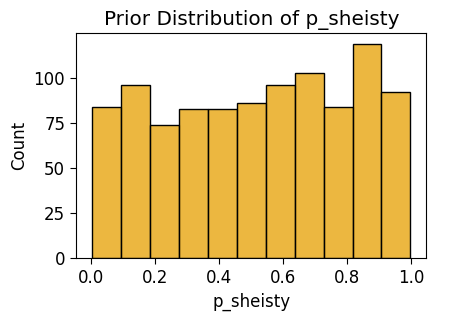

In [49]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="p_sheisty", data=s2_prior_end_df, ax=ax
);
ax.set_title("Prior Distribution of p_sheisty")
ax.savefig()

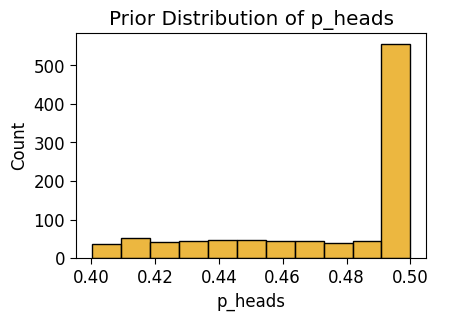

In [50]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="p_heads", data=s2_prior_end_df, ax=ax
);
ax.set_title("Prior Distribution of p_heads")
ax.savefig()

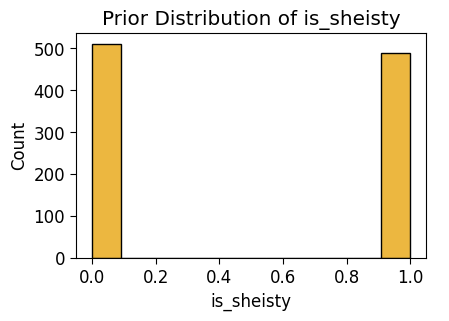

In [51]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="is_sheisty", data=s2_prior_end_df, ax=ax
);
ax.set_title("Prior Distribution of is_sheisty");
ax.savefig()

### [Part 3.3] The Prior *Predictive* Distribution

Now, the vocabulary in this part is going to be a bit confusing at first:

* With the way **we** have defined the model parameters -- `p_sheisty` and `p_heads` as parameters and then `num_heads` (as a vector) and `money final` (as a scalar) as outcomes -- we **do** have a prior predictive distribution her, since we can obtain distributions over the outcomes before actually observing any data. However...
* With the way **PyMC** defines paramters, we don't "unlock" the prior-predictive or posterior-predictive distributions until we actually **provide observed data** to the model.

So, what that means is, don't be fooled by the PyMC terminology (which is for computational convenience -- see e.g. [this post](https://discourse.pymc.io/t/why-is-a-posterior-created-in-pm-model-when-no-data-are-given/12009/6) on their forum about it)! We're going to use the `.prior` attribute of our inference data, but we're using it to carry out a prior-predictive check in this part!<sup>[1]</sup>

---

<small>

1.  I'm going to release a shorter writeup soon where we'll supply the data to our `pm.Model()` right away, so that we'll immediately have access to `.prior`, `.prior_predictive`, `.posterior`, and `.posterior_predictive`!

</small>

First things first, we could infer just from a table of the means and medians of the two models that the bonus-money has had an interesting effect on our expected earnings:

In [52]:
s2_prior_money_df = s2_prior_end_df[['draw','money_at_round_end','money_w_bonus']].copy().melt(id_vars="draw")
s2_prior_money_df.groupby('variable')['value'].agg(['mean','median'])

,mean,median
variable,,
money_at_round_end,-6.536,-6.0
money_w_bonus,0.792,-6.0


Even though the medians are exactly the same, the **means** of the two variables now differ in an important way, with one above 0 and the other well below 0. To get a visual for why this happens, let's plot two posterior-predictive distributions here, on the same axes, to see how the doubling-of-positive-winnings dynamic affects the distribution of outcomes (as well as the ultimate expected value!)

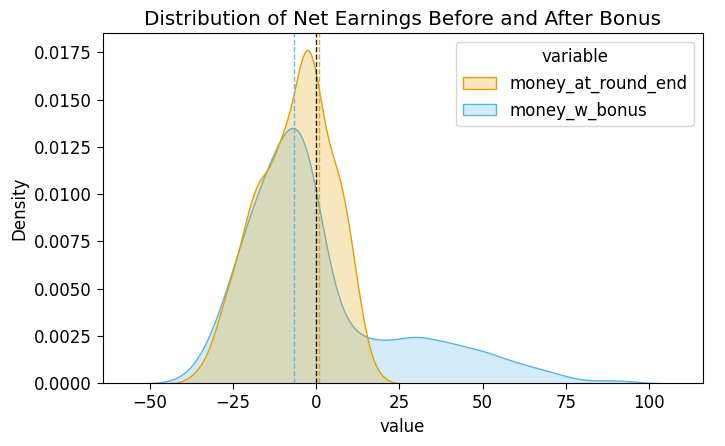

In [53]:
prior_mean_money_nb = s2_prior_end_df['money_at_round_end'].mean()
prior_mean_money = s2_prior_end_df['money_w_bonus'].mean()
ax = pw.Brick(figsize=(6, 3.5));
sns.kdeplot(
    x="value", hue="variable", data=s2_prior_money_df, ax=ax,
    fill=True
);
ax.axvline(x=0, color='black', ls='dashed', lw=1, alpha=0.9);
ax.axvline(x=prior_mean_money_nb, color=cb_palette[1], ls='dashed', lw=1, alpha=0.9);
ax.axvline(x=prior_mean_money, color=cb_palette[0], ls='dashed', lw=1, alpha=0.9);
ax.set_title("Distribution of Net Earnings Before and After Bonus");
ax.savefig()

So, that's the prior-predictive distribution with respect to the **final** end-of-match payout, where we can already see (from the dashed vertical lines) that the bonus makes playing the game **ever-so-slightly worth it**, with an expected value now slightly above €0. This plot also explains why only the **mean** was affected: the bonus only affected the final money amounts by scaling up outcomes which were already above the 50% mark, leaving the median (the observation with exactly 50% of observations above it) unchanged.

And, since our model has two levels (round-level and match-level), we can also use our prior-predictive distribution to visualize the **distribution of trajectories**:

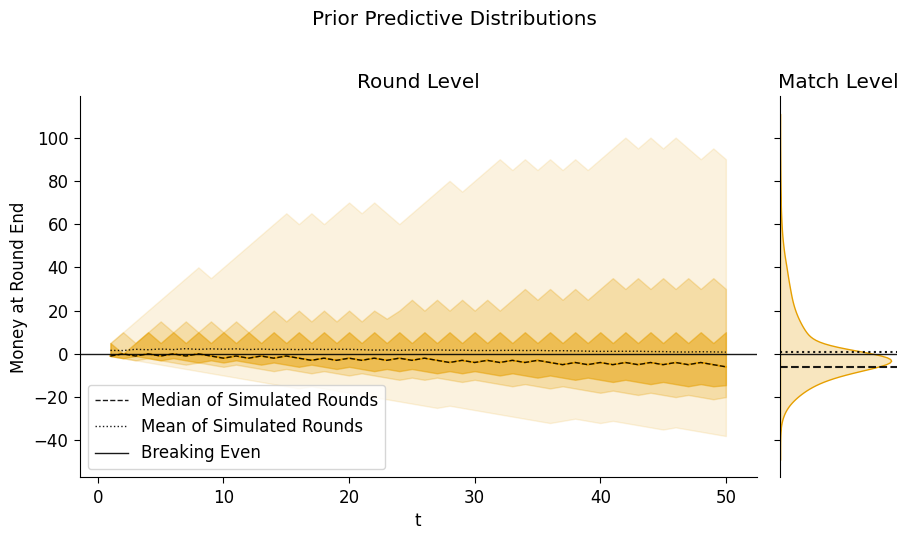

In [54]:
def plot_predictive_trajectories(df, suptitle, custom_bw_adjust=2):
    # Add a special t=0 row to each match, so the plotted trajectories start at
    # (t,y) = (0,0)
    t0_df = pd.DataFrame({'t': 0, 'money_w_bonus': 0, 'draw': range(df['draw'].max())})
    plot_df = pd.concat([t0_df, df])
    end_df = df[df['t'] == S2Game.rounds_per_match].copy()
    mean_money = end_df['money_w_bonus'].mean()
    med_money = end_df['money_w_bonus'].median()
    
    grid = sns.JointGrid(height=5.25) #, ylim=(-30,15));
    grid.ax_marg_x.remove();
    # Mean lines
    full_range_plot = sns.lineplot(
        x="t", y="money_w_bonus",
        data=df, ax=grid.ax_joint,
        color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',100),
        lw=1,
        err_kws=dict(alpha=0.125),
    );
    sns.lineplot(
        x="t", y="money_w_bonus",
        data=df, ax=grid.ax_joint,
        color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',75),
        lw=1,
        err_kws=dict(alpha=0.25),
    );
    sns.lineplot(
        x="t", y="money_w_bonus",
        data=df, ax=grid.ax_joint,
        color=cb_palette[0],
        estimator='median',
        #errorbar=None,
        errorbar=('pi',50),
        lw=1,
        err_kws=dict(alpha=0.5),
    );
    # Median trajectory outline in black
    sns.lineplot(
        x="t", y="money_w_bonus", label="Median of Simulated Rounds",
        data=df, ax=grid.ax_joint,
        color='black', alpha=0.9,
        estimator='median',
        errorbar=None,
        lw=1, ls='dashed',
    );
    # Mean trajectory
    sns.lineplot(
        x="t", y="money_w_bonus", label="Mean of Simulated Rounds",
        data=df, ax=grid.ax_joint,
        color='black', alpha=0.9,
        estimator='mean',
        errorbar=None,
        lw=1, ls='dotted',
    );
    grid.refline(
        y=0, color='black', lw=1, ls='solid', label='Breaking Even', alpha=0.9
    );
    # prior_grid.refline(
    #     y=biased_end_df['money_at_round_end'].mean(),
    #     color=cb_palette[1], lw=2,
    #     label='Expected Payoff'
    # );
    grid.ax_joint.legend(loc="lower left");
    # plt.legend(['Breaking Even','Your Expected Payoff'], loc="left")
    
    sns.kdeplot(
        y="money_w_bonus", data=df,
        ax=grid.ax_marg_y, fill=True, legend=False,
        bw_adjust=custom_bw_adjust,
        # stat='density',
        # discrete=True,
        # shrink=0.5,
    );
    # Line on margin for mean
    grid.ax_marg_y.axhline(
        y=mean_money, color='black', ls='dotted', alpha=0.9
    );
    grid.ax_marg_y.axhline(
        y=med_money, color='black', ls='dashed', alpha=0.9
    );
    grid.ax_joint.set_ylabel("Money at Round End");
    grid.ax_joint.set_title("Round Level");
    grid.ax_marg_y.set_title("Match Level");
    grid.fig.suptitle(suptitle);
    grid.fig.set_figwidth(9.5);
    return grid
plot_predictive_trajectories(
    s2_prior_df,
    suptitle="Prior Predictive Distributions"
);

So now we can see, from this and the previous plot, that **given our uncertainty about `p_sheisty` and `p_heads`**, it is **just barely worthwhile to play!** Even though the **median** of the game with and without the beating-sheisty bonus is the same, the **mean** with the bonus is just above €0.

In other words, **given our state of knowledge about the game** at this point, it **is** worthwhile to play (at least, on the assumption that we play if $\mathbb{E}[Y] > 0$.

However, each time you play a match with $B$, you will obtain some **information** about (a) whether or not they have the **Sheisty Coin**, and then (b) **if they do** have it, what their bias level may be. So, in the next part we'll simulate playing one round and then updating based on the results.

## [Part 4] Updating On Observed Data

Now, let's say you play one match with your friend, and you're trying to determine whether it's worthwhile to keep playing with them... How exactly would you figure this out? By what specific amounts should you **update** your distribution over `p_sheisty` and `p_heads`?

You could sit down and solve a gigantic 5100-style problem... or just **plug the data into your Bayesian inference machine**, namely, **PyMC** 😊

### [Part 4.1] Your (Single) Observed Match

Here we'll finally reveal the secret: though you, as player $A$, don't know it (this is the **true DGP** we're simulating, finally, which is **not observable** to the actual agents playing the game!), player $B$ **does** indeed have the Sheisty Coin, and the random bias they've obtained puts their `p_heads` at **0.41**.

So, let's simulate one match with this coin, keeping in mind that you-as-player-$A$ **don't know** that this data was generated via $p = 0.48$ -- you **only know** that the match ended up with the following trajectory and outcome:

In [55]:
true_is_sheisty = 1
true_p_heads = 0.48

In [56]:
def sim_s2_match(p, rng_seed=5650):
    sim_rng = np.random.default_rng(seed=rng_seed)
    round_outcomes = sim_rng.binomial(n=Game.flips_per_round, p=p, size=Game.rounds_per_match)
    match_df = pd.DataFrame({'t': range(1,Game.rounds_per_match+1), 'num_heads': round_outcomes})
    match_df['money_change'] = -1 + 2 * (match_df['num_heads'] > Game.win_cutoff)
    match_df['money_at_round_end'] = match_df['money_change'].cumsum()
    # New in Season 2: Quintupling your money when it's above 0!
    match_df['money_w_bonus'] = match_df['money_at_round_end'].apply(lambda x: S2Game.bonus_multiplier * x if x > 0 else x) 
    t0_df = pd.DataFrame({'t':[0],'money_at_round_end':[0],'money_change':[0]})
    match_df = pd.concat([t0_df, match_df])
    return(match_df)
obs_df = sim_s2_match(true_p_heads)
obs_df.tail()

,t,money_at_round_end,money_change,num_heads,money_w_bonus
45,46,-14,1,8.0,-14.0
46,47,-15,-1,4.0,-15.0
47,48,-14,1,8.0,-14.0
48,49,-13,1,7.0,-13.0
49,50,-14,-1,5.0,-14.0


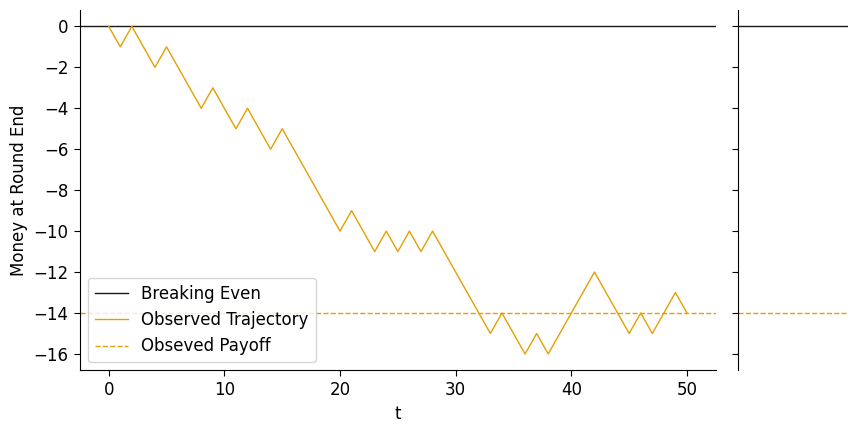

In [57]:
obs_grid = sns.JointGrid(height=5) # , ylim=(-30,15));
obs_grid.refline(
    y=0, color='black', alpha=0.9, lw=1, ls='solid', label='Breaking Even'
);
# Mean lines
sns.lineplot(
    x="t", y="money_at_round_end", label="Observed Trajectory",
    data=obs_df, ax=obs_grid.ax_joint,
    estimator='median',
    #errorbar=None,
    errorbar=('pi',50),
    lw=1,
    err_kws=dict(alpha=0.15),
);
obs_grid.ax_marg_x.remove();
obs_grid.refline(
    y=obs_df.iloc[-1]['money_at_round_end'],
    color=cb_palette[0], lw=1,
    label='Obseved Payoff'
);
obs_grid.ax_joint.legend(loc="lower left");
# plt.legend(['Breaking Even','Your Expected Payoff'], loc="left")

# sns.kdeplot(
#     y="money_at_round_end", hue="params", data=combined_end_df,
#     ax=biased_grid.ax_marg_y, fill=True, legend=False,
#     # stat='density',
#     # discrete=True,
#     # shrink=0.5,
# );
obs_grid.ax_joint.set_ylabel("Money at Round End");
obs_grid.fig.set_figwidth(9)

So, by the end of this match, you ended up with €14 less than you started with. If you only knew this final amount, you would essentially have one "bit" of information. However, you have more than this! You also know the **trajectory** from $t = 0$ to $t = 50$, which gives you much more information you can use to update your model parameters.

Let's use PyMC as it was fully intended, by pairing our model with this **observed data**, and then see how this changes whether or not it's still worth it to play against $B$!

### [Part 4.2] Adding the Observations to Our Model and Updating

Since our model doesn't actually incorporate the $t = 0$ row (we added that just to make the plots a bit more readable), we drop these rows and then set `obs_df` without these rows as the observed data for our model.

In [58]:
obs_t1_df = obs_df[obs_df['t'] > 0].copy().set_index('t')

In [59]:
coords = {
    't': list(range(1, Game.rounds_per_match + 1))
}
with pm.Model(coords=coords) as s2_model_obs:
    # Unobservable prior parameters
    p_sheisty = pm.Uniform("p_sheisty", 0, 1)
    is_sheisty = pm.Bernoulli("is_sheisty", p=p_sheisty)
    fair_p_heads = 0.5
    sheisty_p_heads = pm.Uniform("sheisty_p_heads", 0.4, 0.5)
    p_heads = pm.Deterministic(
        "p_heads",
        pm.math.switch(
            is_sheisty,
            sheisty_p_heads,
            fair_p_heads
        )
    )
    # Observable parameters
    # The flips
    num_heads = pm.Binomial(
        "num_heads", n=Game.flips_per_round, p=p_heads,
        dims='t', observed=obs_t1_df['num_heads']
    )
    # The round result
    money_change = pm.Deterministic(
        "money_change",
        pm.math.switch(pm.math.gt(num_heads, Game.win_cutoff), 1, -1),
        dims='t'
    )
    # The cumulative result
    money_at_round_end = pm.Deterministic(
        "money_at_round_end",
        pm.math.cumsum(money_change, 0),
        dims='t'
    )
    # And the doubling-at-end if we win
    money_w_bonus = pm.Deterministic(
        "money_w_bonus",
        pm.math.switch(
            pm.math.gt(money_at_round_end, 0),
            S2Game.bonus_multiplier * money_at_round_end,
            money_at_round_end
        ),
        dims='t'
    )

### [Part 4.3] Sample from Posterior Distribution

In [60]:
with s2_model_obs:
    s2_post_idata = pm.sample(random_seed=5650)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_sheisty, sheisty_p_heads]
>BinaryGibbsMetropolis: [is_sheisty]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [62]:
s2_post_df = s2_post_idata.posterior.to_dataframe().reset_index()
s2_post_df

,chain,draw,t,is_sheisty,p_sheisty,sheisty_p_heads,p_heads,money_change,money_at_round_end,money_w_bonus
0,0,0,1,1,0.634665,0.425275,0.425275,-1,-1,-1
1,0,0,2,1,0.634665,0.425275,0.425275,1,0,0
2,0,0,3,1,0.634665,0.425275,0.425275,-1,-1,-1
3,0,0,4,1,0.634665,0.425275,0.425275,-1,-2,-2
4,0,0,5,1,0.634665,0.425275,0.425275,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
199995,3,999,46,1,0.902354,0.431539,0.431539,1,-14,-14
199996,3,999,47,1,0.902354,0.431539,0.431539,-1,-15,-15
199997,3,999,48,1,0.902354,0.431539,0.431539,1,-14,-14
199998,3,999,49,1,0.902354,0.431539,0.431539,1,-13,-13


In [63]:
s2_post_end_df = s2_post_df[s2_post_df['t'] == S2Game.rounds_per_match].copy()
s2_post_end_df

,chain,draw,t,is_sheisty,p_sheisty,sheisty_p_heads,p_heads,money_change,money_at_round_end,money_w_bonus
49,0,0,50,1,0.634665,0.425275,0.425275,-1,-14,-14
99,0,1,50,1,0.941787,0.466247,0.466247,-1,-14,-14
149,0,2,50,1,0.201438,0.432916,0.432916,-1,-14,-14
199,0,3,50,1,0.910678,0.445946,0.445946,-1,-14,-14
249,0,4,50,1,0.500935,0.446615,0.446615,-1,-14,-14
...,...,...,...,...,...,...,...,...,...,...
199799,3,995,50,1,0.204122,0.475606,0.475606,-1,-14,-14
199849,3,996,50,1,0.915687,0.422559,0.422559,-1,-14,-14
199899,3,997,50,1,0.321373,0.466857,0.466857,-1,-14,-14
199949,3,998,50,1,0.486654,0.461348,0.461348,-1,-14,-14


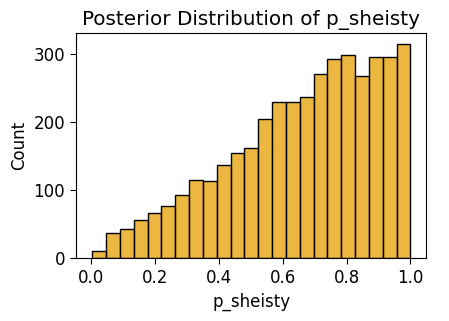

In [64]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="p_sheisty", data=s2_post_end_df, ax=ax
);
ax.set_title("Posterior Distribution of p_sheisty");
ax.savefig()

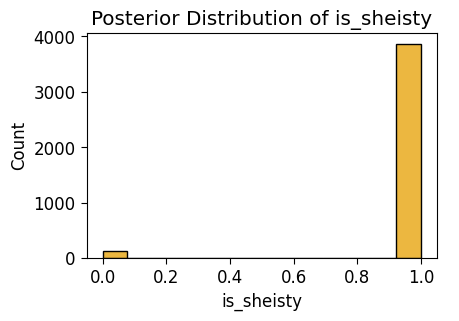

In [65]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="is_sheisty", data=s2_post_end_df, ax=ax
);
ax.set_title("Posterior Distribution of is_sheisty");
ax.savefig()

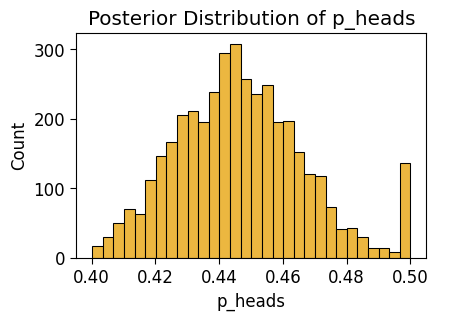

In [66]:
ax = pw.Brick(figsize=(3.5, 2.25));
sns.histplot(
    x="p_heads", data=s2_post_end_df, ax=ax
);
ax.set_title("Posterior Distribution of p_heads");
ax.savefig()

### [Part 4.4] Sample from Posterior *Predictive* Distribution

In [67]:
with s2_model_obs:
    s2_post_pred_idata = pm.sample_posterior_predictive(s2_post_idata, random_seed=5650)

Sampling: [num_heads]


Output()

In [68]:
s2_post_pred_df = s2_post_pred_idata.posterior_predictive.to_dataframe().reset_index()
s2_post_pred_df['source'] = "Posterior Predictive"
s2_post_pred_df

,chain,draw,t,num_heads,money_change,money_at_round_end,money_w_bonus,source
0,0,0,1,5,-1,-1,-1,Posterior Predictive
1,0,0,2,5,-1,-2,-2,Posterior Predictive
2,0,0,3,3,-1,-3,-3,Posterior Predictive
3,0,0,4,0,-1,-4,-4,Posterior Predictive
4,0,0,5,4,-1,-5,-5,Posterior Predictive
...,...,...,...,...,...,...,...,...
199995,3,999,46,7,1,-16,-16,Posterior Predictive
199996,3,999,47,5,-1,-17,-17,Posterior Predictive
199997,3,999,48,5,-1,-18,-18,Posterior Predictive
199998,3,999,49,4,-1,-19,-19,Posterior Predictive


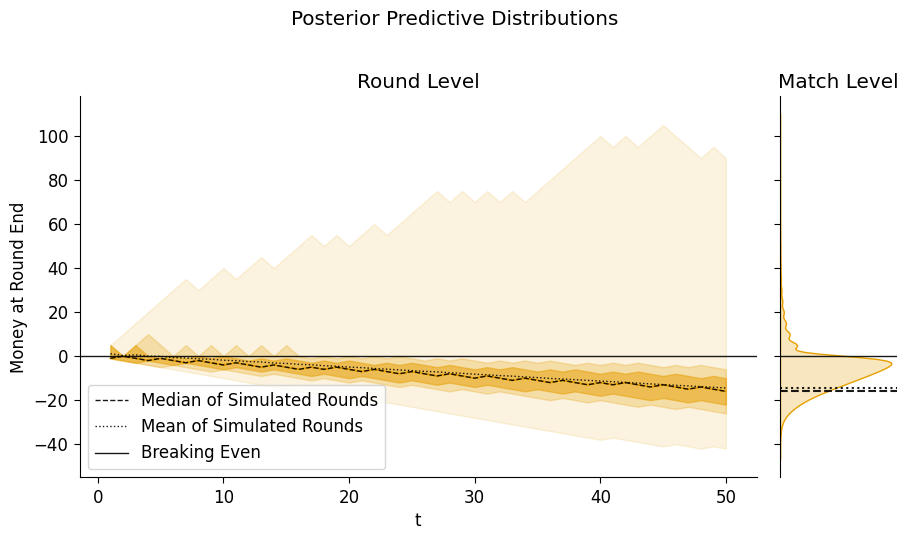

In [69]:
plot_predictive_trajectories(
    s2_post_pred_df,
    suptitle="Posterior Predictive Distributions"
);

So... by incorporating what we learned from the one round about the possibility that $B$ has the Sheisty Coin, we've learn that it is **no longer worthwhile** to keep playing against $B$!

We can see, up in the portion above the "Breaking Even" line, the tantalizing 1% of matches that end in huge fortunes for us. Taking this **risk-reward tradeoff** into account would take us into the even more... complex-but-important realm of **Bayesian Decision Theory!**

As a motivation to take the additional deep-dive into this field, imo it is **especially, incredibly important** for those interested in public policy. The Minnesota Radon data mentioned in class, for example, was part of a much broader case-study of how Bayesian data analysis can be used to provide policy recommendations, and following the Bayesian Workflow beyond the contents of this notebook and into Bayesian Decision Theory will allow you to construct plots like this, providing explicit Bayes-Theorem-optimized recommendations to policymakers:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/45847ccbb4798499bb9bd91a145f67d9f96257a2/2025-sum-dsan5650/writeups/decision.svg" width="85%"></img>
<figcaption><i>The Bayesian Decision Analysis plot from <b>Gelman et al. (2014), Bayesian Data Analysis (Third Edition)</b></i></figcaption>
</figure>
</center>